# Part I:  Research Question

## A.  Describe the purpose of this data analysis by doing the following:

#### A1:Research Question

What will be the estimated revenue next year?

#### A2:Objectives and Goals

1) Review the sequence of data(observations of revenue overtime) and identify patterns represented within. 

2) Using sequence forecast or predict future revenue.


# Part II:  Method Justification


#### B:Summary of Assumptions

First assumption is the data is stationary. Stationary data means the mean, variance, and autocorrelation don't change over time.

Second assumption is autocorrelation of data. This means values separated by an iteration may have positive or negative correlations. When this exists it will indicate indicate that past values have influence on current values. Because of this autocorrelation, business understanding of seasonality and events such as catastrophic weather, substantial influence like sporting events or other anomoly based events are accounted for. 

# Part III:  Data Preparation


#### C1:Line Graph Visualization

In [1]:
#### LOAD LIBRARIES
##### system
import sys, os
from time import time

##### Data
import pandas as pd
import numpy as np


###### stats
import scipy.stats as stats
import math
import statsmodels.api as sm

##### Visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

#### PreProcessing Test train split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, train_test_split, StratifiedShuffleSplit, cross_val_score
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion


#### Models
from sklearn.cluster import KMeans


#### Evaluation of Models
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import mean_squared_error as MSE

import warnings
warnings.filterwarnings('ignore')

In [4]:
file = pd.read_csv('C://Users//matth//Desktop//DATA//teleco_time_series.csv',index_col = 'Day', parse_dates = True)
file.head()

,Revenue
Day,
1,0.000000
2,0.000793
3,0.825542
4,0.320332
5,1.082554


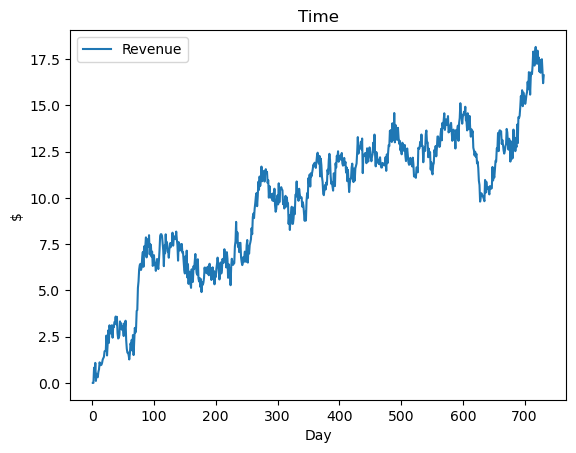

In [5]:
file.plot()
plt.title("Time")
plt.ylabel("$")
plt.show();

In [6]:
import datetime
file['Date'] = (pd.date_range(start=datetime.datetime(2019, 1, 1),
                           periods=file.shape[0], freq='24H'))
file.set_index('Date', inplace = True)
file


,Revenue
Date,
2019-01-01,0.000000
2019-01-02,0.000793
2019-01-03,0.825542
2019-01-04,0.320332
2019-01-05,1.082554
...,...
2020-12-27,16.931559
2020-12-28,17.490666
2020-12-29,16.803638


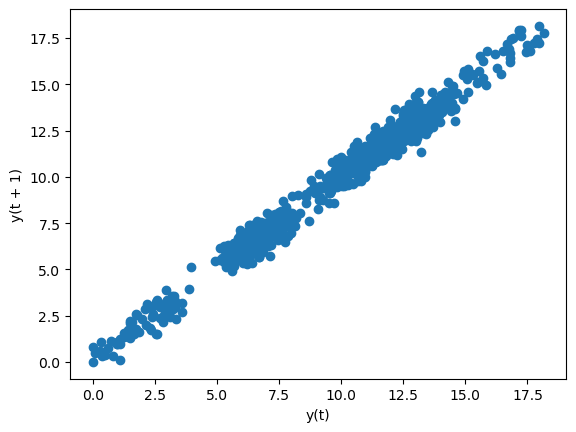

In [7]:
# import lag_plot function
from pandas.plotting import lag_plot
# lag scatter plot
lag_plot(file)
plt.show()

#### C2:Time Step Formatting

In [8]:
# Check for missing data
nulls = (file.isnull().values.any())
NaN = (file.isna().values.any())
print('Nans :',NaN, "\n"'Nulls:', nulls)

Nans : False 
Nulls: False


In [9]:
# Drop Duplicates
'''Normally we would want to drop duplicates however with retail sales we will make an assumption 
that there can be a potential for duplicate sales or reallocation etc causing relevent duplicate data.
For now we will account whether there is duplicate data or not in the dataset and work with the business on 
resolving case by case'''
duplicates = (file.duplicated().sum())
print('Duplicates:', duplicates)

Duplicates: 0


In [10]:
# just to be thorough

In [11]:
# drop zero values
file = file[file['Revenue'] != 0]

In [12]:
## remove any blanks
for col in file:
    blanks = []
    if file.columns.isna().any()== True:
        blanks = col
print(blanks)

[]


In [13]:
# Remove blank spaces
file = file.replace(" ", "")

In [14]:
file_null = file.isnull().any()
print(file_null)

Revenue    False
dtype: bool


- according to metadata the company has been in business for 2 years. It is currently November 2022 will rollback data as if it was 2019 to ensure all data is captured. 

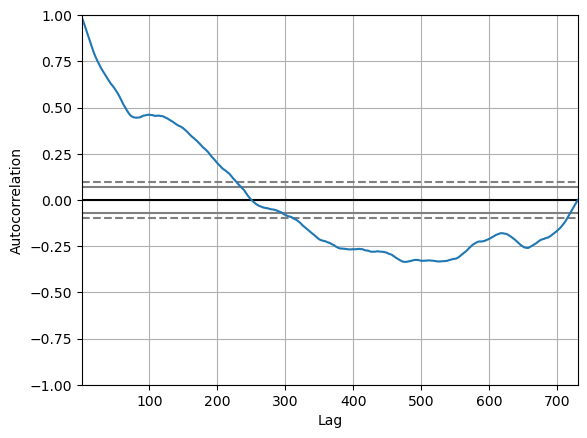

In [15]:
# import autocorrelation function
from pandas.plotting import autocorrelation_plot

# autocorrelation plot
autocorrelation_plot(file)
plt.show()

In [16]:
# some basic exploration to ensure no gaps in data and understand length and distribution of data

In [17]:
file.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2019-01-02 to 2020-12-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  730 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


In [18]:
file.describe()

,Revenue
count,730.000000
mean,9.836357
std,3.838059
min,0.000793
25%,6.905127
50%,10.794862
75%,12.567476
max,18.154769


In [19]:
file.shape

(730, 1)

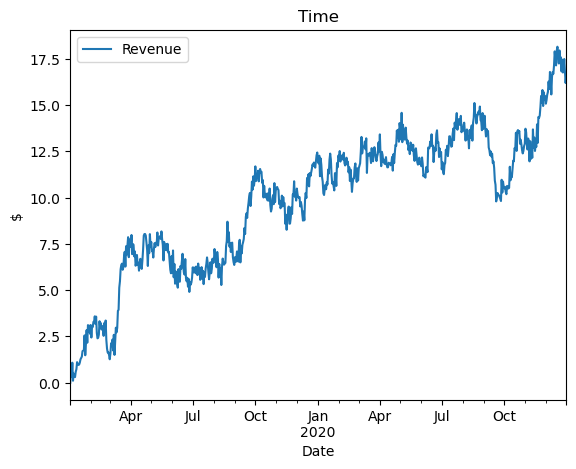

In [20]:
file.plot()
plt.title("Time")
plt.ylabel("$")
plt.show();

#### C3:Stationarity

In [21]:
from statsmodels.tsa.stattools import adfuller
def adf_results(timeseries):
    ('ADF Test:')
    adf = adfuller(timeseries, autolag='AIC')
    adfoutput = pd.Series(adf[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print (adfoutput)
adf_results(file['Revenue'])

Test Statistic                  -1.774638
p-value                          0.393124
#Lags Used                       1.000000
Number of Observations Used    728.000000
dtype: float64


Our first null hypothesis is that the data is stationary. 
Because the p value is not .05, meaning the data is statisicaly significant,  we can reject the null hypotheseis that this is stationary data. 
For this reasone we will prepare data using Arima method. 

#### C4:Steps to Prepare the Data

In [22]:
adf_results(file['Revenue'])

Test Statistic                  -1.774638
p-value                          0.393124
#Lags Used                       1.000000
Number of Observations Used    728.000000
dtype: float64


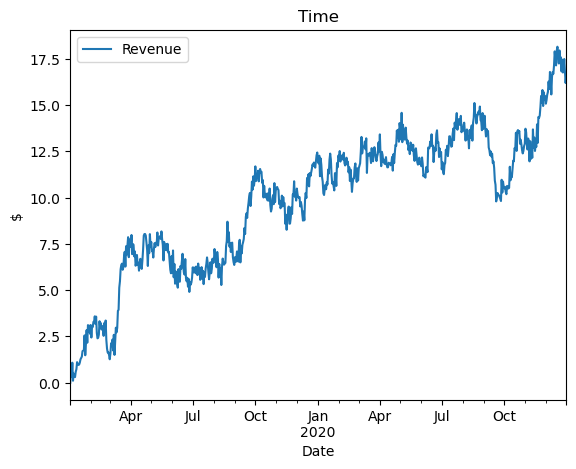

In [23]:
file.plot()
plt.title("Time")
plt.ylabel("$")
plt.show();

In [24]:
file.tail

<bound method NDFrame.tail of               Revenue
Date                 
2019-01-02   0.000793
2019-01-03   0.825542
2019-01-04   0.320332
2019-01-05   1.082554
2019-01-06   0.107654
...               ...
2020-12-27  16.931559
2020-12-28  17.490666
2020-12-29  16.803638
2020-12-30  16.194813
2020-12-31  16.620798

[730 rows x 1 columns]>

In [25]:
X = file.loc[:'2020-09-30']
y = file.loc['2020-10-01':]
print('X', X.shape)
print('y', y.shape)

X (638, 1)
y (92, 1)


#### C5:Prepared Dataset
    The submission provides a copy of a fully prepared, cleaned data set.

In [26]:
file.to_csv('d213_task1_clean.csv')

# Part IV:  Model Identification and Analysis

#### D1:Report Findings and Visualizations

•   the presence or lack of a seasonal component

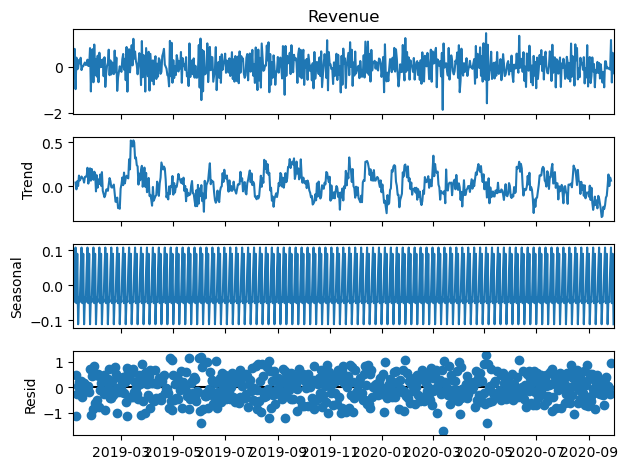

In [27]:
# Decompose the training set
df_diff = X.diff().dropna()
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df_diff['Revenue'])
decomp.plot()
plt.show()




•   trends

<Axes: xlabel='Date'>

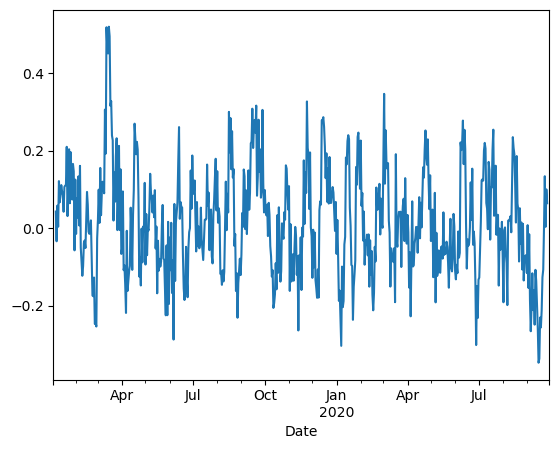

In [28]:
decomp.trend.plot()

•   auto correlation function

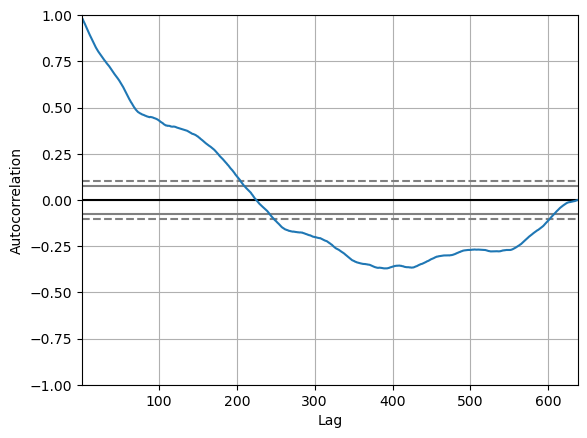

In [29]:
# autocorrelation plot
autocorrelation_plot(X)
plt.show()

 •   spectral density

(array([6.99761773e+03, 3.92195106e+03, 5.32366740e+01, 1.08164074e+01,
        4.15584534e+00, 8.66439161e+00, 9.17414025e+00, 5.00501299e+00,
        4.47731021e+00, 1.90264456e+00, 3.17325855e+00, 2.05367087e+00,
        1.25432645e-01, 9.08664523e-01, 1.57504434e+00, 1.83377207e+00,
        1.36196985e+00, 1.08282308e+00, 3.68753231e-01, 3.99349969e-01,
        6.66454271e-01, 4.38190186e-01, 1.07762240e+00, 4.98560932e-01,
        1.48353107e-01, 2.04781138e-01, 2.00959928e-01, 3.62365593e-02,
        4.70033795e-01, 5.45617420e-01, 2.41614474e-01, 4.69757077e-01,
        2.81388733e-01, 7.70931982e-02, 2.43662146e-01, 7.20747595e-02,
        3.59300342e-01, 2.15487711e-01, 1.21344156e-01, 1.72775590e-01,
        1.70890417e-01, 1.14848552e-01, 2.14638346e-01, 2.81419434e-01,
        3.21378283e-02, 1.63348698e-02, 3.99213370e-02, 6.36974476e-02,
        4.66852546e-02, 6.69023656e-02, 1.74086429e-01, 1.34267523e-01,
        6.76164491e-02, 1.57204333e-02, 1.41818894e-01, 1.218561

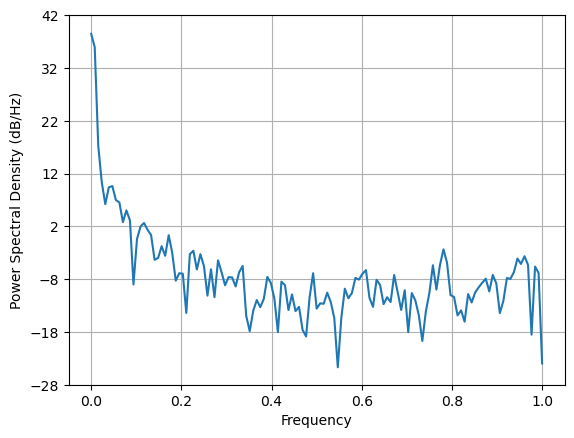

In [30]:
plt.psd(X['Revenue'])

•   the decomposed time series

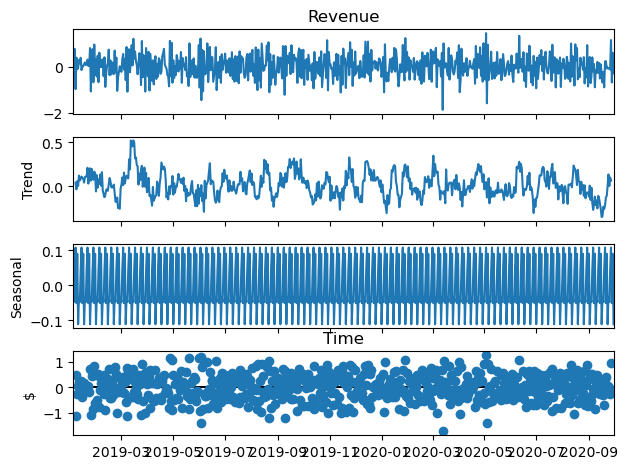

In [31]:
decomp.plot()
plt.title("Time")
plt.ylabel("$")
plt.show();

•   confirmation of the lack of trends in the residuals of the decomposed series

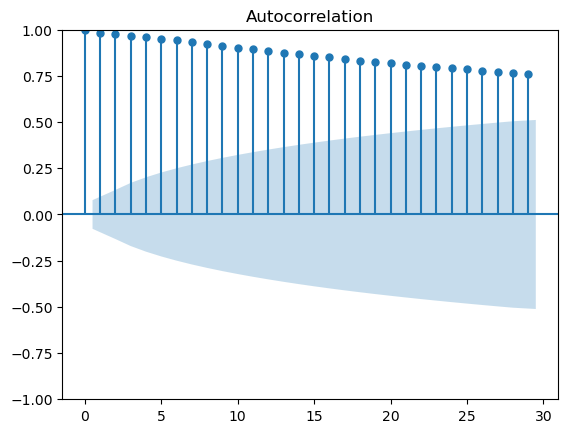

In [32]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(X);


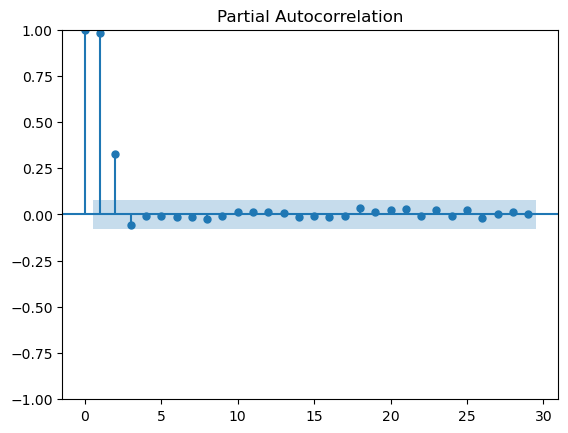

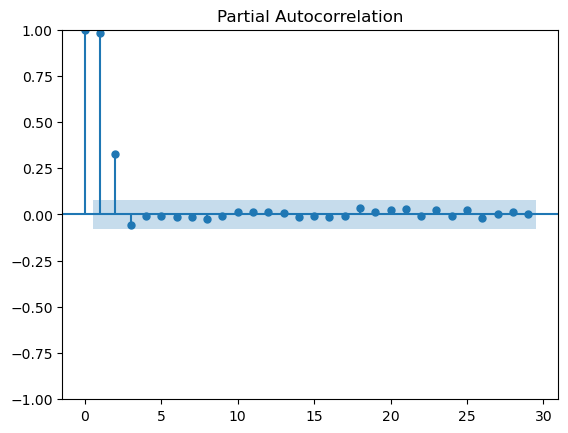

In [33]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(X)

<Axes: xlabel='Date'>

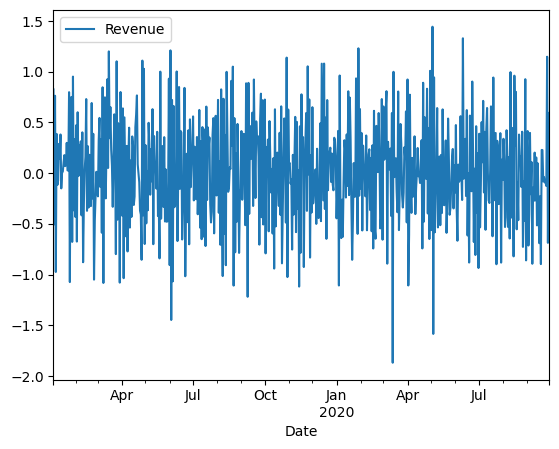

In [34]:
df_train_diff = X.diff().dropna()
df_train_diff.plot()

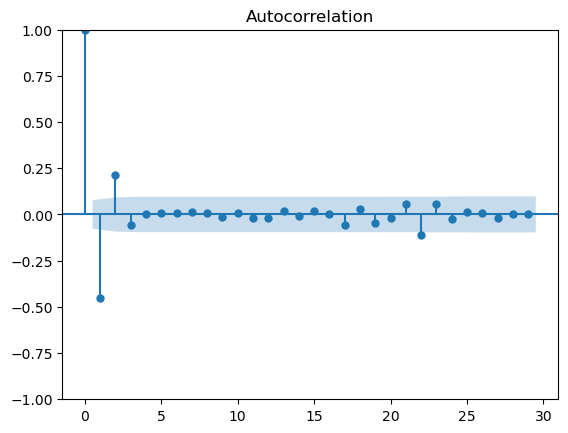

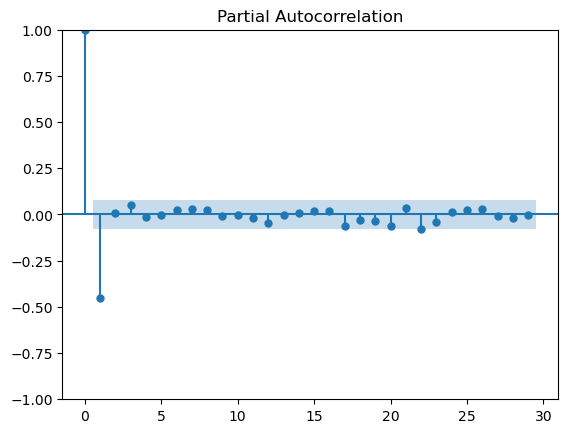

In [35]:
acf_diff = plot_acf(df_train_diff)

pacf_diff = plot_pacf(df_train_diff)

In [36]:
adf_results(df_train_diff['Revenue'])

Test Statistic                 -41.216675
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    636.000000
dtype: float64


In [37]:
adf_test = adfuller(df_train_diff)
print(f'p-value: {adf_test[1]}')

p-value: 0.0


#### D2:ARIMA Model

Why are we using Arima Model? Because our data has a history or revenue by day Arima can take the past performance to make future predictions as Neha Bora, Principal Associate, Data Science says in her Article, "Understanding ARIMA Models for Machine Learning", Capitol One Machine Learning. (2006)
"It is widely used in demand forecasting, such as in determining future demand in food manufacturing. That is because the model provides managers with reliable guidelines in making decisions related to supply chains. ARIMA models can also be used to predict the future price of your stocks based on the past prices."

In [117]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(X, order=(4,2,3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  638
Model:                 ARIMA(4, 2, 3)   Log Likelihood                -419.257
Date:                Thu, 29 Feb 2024   AIC                            854.513
Time:                        10:36:34   BIC                            890.155
Sample:                    01-02-2019   HQIC                           868.351
                         - 09-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.0074      0.040    -49.966      0.000      -2.086      -1.929
ar.L2         -1.6784      0.088    -19.170      0.000      -1.850      -1.507
ar.L3         -0.4125      0.087     -4.746      0.0

#### D3:Forecasting using ARIMA Model

In [113]:
mae = np.mean(np.abs(model_fit.resid))
print("The mean absolute error is:", round(mae,2))

The mean absolute error is: 0.38


By interpreting the autocorrelation and Partial Auto correlation I manipulated the PDQ inputs and continued to get .37 and .38 outputs. By increasing the D to 2 this still resulted in this low .38 output. This is an indication in Data that needs further cleaning. 

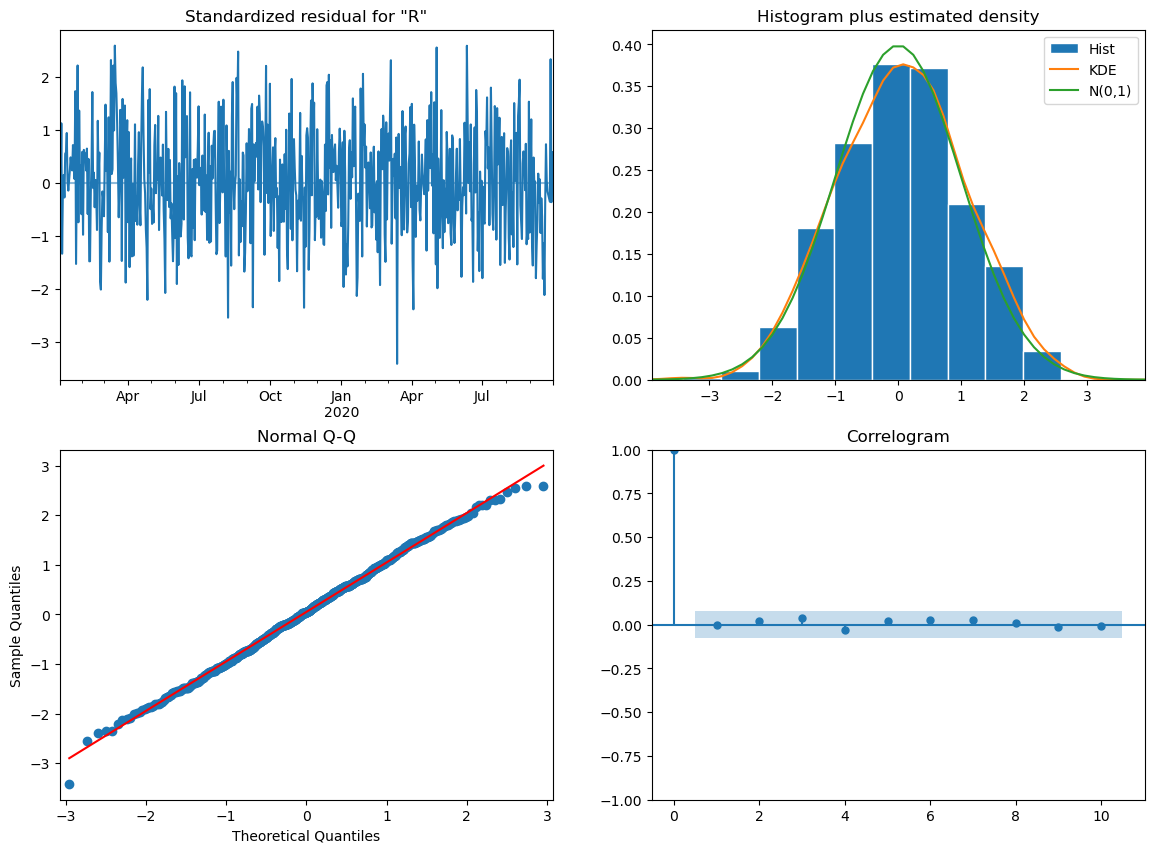

In [40]:
model_fit.plot_diagnostics(figsize=(14,10))
plt.show()

In [41]:
pred = model_fit.get_prediction(start=512, end=790)
print(pred.summary_frame(alpha=0.05))

Revenue          mean   mean_se  mean_ci_lower  mean_ci_upper
2020-05-28  11.836655  0.468063      10.919268      12.754042
2020-05-29  11.858082  0.468063      10.940695      12.775469
2020-05-30  12.053931  0.468063      11.136544      12.971318
2020-05-31  11.969869  0.468063      11.052482      12.887256
2020-06-01  11.849929  0.468063      10.932542      12.767316
...               ...       ...            ...            ...
2021-02-26  10.675948  3.988182       2.859255      18.492641
2021-02-27  10.675948  4.001468       2.833214      18.518682
2021-02-28  10.675948  4.014710       2.807260      18.544636
2021-03-01  10.675948  4.027909       2.781391      18.570505
2021-03-02  10.675948  4.041065       2.755606      18.596290

[279 rows x 4 columns]


In [42]:
model_fit.forecast(90)


2020-10-01    10.720091
2020-10-02    10.654990
2020-10-03    10.685898
2020-10-04    10.671224
2020-10-05    10.678191
                ...    
2020-12-25    10.675948
2020-12-26    10.675948
2020-12-27    10.675948
2020-12-28    10.675948
2020-12-29    10.675948
Freq: D, Name: predicted_mean, Length: 90, dtype: float64

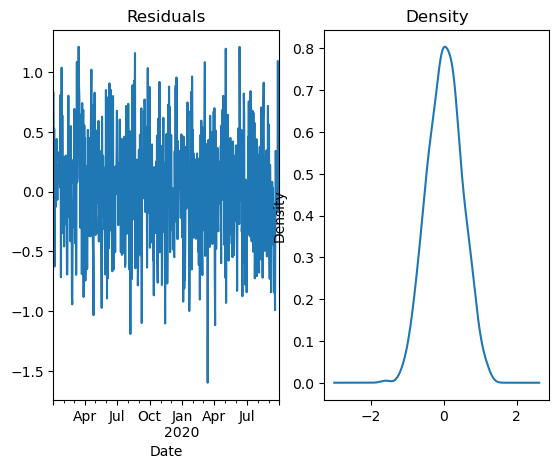

In [43]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

In [44]:
# prediction for quarter
pred = model_fit.predict(start=640, end=790, type='levels')
print(pred)

2020-10-03    10.685898
2020-10-04    10.671224
2020-10-05    10.678191
2020-10-06    10.674883
2020-10-07    10.676454
                ...    
2021-02-26    10.675948
2021-02-27    10.675948
2021-02-28    10.675948
2021-03-01    10.675948
2021-03-02    10.675948
Freq: D, Name: predicted_mean, Length: 151, dtype: float64


# Part V:  Data Summary and Implications

## E.  Summarize your findings and assumptions, including the following points:

1.  Discuss the results of your data analysis, including the following:

    *   the selection of an ARIMA model
    
    *   the prediction interval of the forecast
    
    *   a justification of the forecast length
    
    *   the model evaluation procedure and error metric

2.  Provide an annotated visualization of the forecast of the final model compared to the test set.

3.  Recommend a course of action based on your results.

#### E2:Annotated Visualization
As can be observed we have a strong upward trend

<Axes: xlabel='Date'>

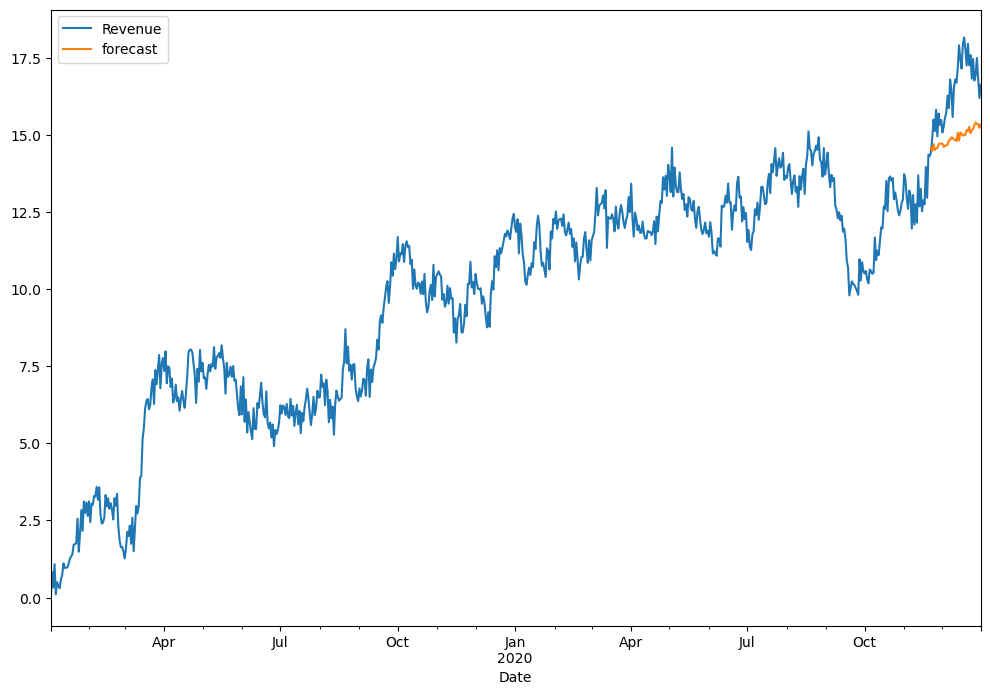

In [133]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(file['Revenue'],order=(1, 1, 1),seasonal_order=(3,1,3,28))
results=model.fit()
file['forecast']=results.predict(start=690,end=790,dynamic=True)
file[['Revenue','forecast']].plot(figsize=(12,8))

#### E3:Recommendations

With an MSE score of .38 there is room for improvement but as we can see the prediction is trending correctly. Next steps will be to:
Review preperation process to discover segments of data, explore dips and spikes(is the store closed, are we running promos, holidays). After evaluating outliers exploring difference techniques to capture the correct smoothing will tune this model to fit the upwar